<a href="https://colab.research.google.com/github/AnToxa0887/innopolis_2/blob/main/Diplom_Kuzmin_Anton_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Дипломная работа по анализу датасета "Ежемесячное производства молока"**





**Введение. Постановка целей и задач.**

В качестве исследования для дипломный работы был выбран датасет с показателем ежемесячного производства молока с 1962 по 1975г.г. Посмотрим на данном примере как изменялось производство молока как в течении одного года, так и на протяжении 14 лет. 

**Цель исследования:** спрогнозировать возможность дальнейшего роста производства молока.

**Задачи:**

1.   Провести анализ данных о ежемесячном производстве молока;
2.   Построить прогноз производства молока в последующие годы.

**1. Импорт Датафрейма, библиотек, написание функций.**

Для выполнения нашей задачи необходимо загрузить библиотеки обработки данных 

In [ ]:
# загружаем pmdarima
!pip install pmdarima

In [ ]:
# загружаем fbprophet
!pip install fbprophet

In [ ]:
## Импортируем библиотеки и функции 
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

# импорт моделей 
from statsmodels.tsa.statespace.sarimax import SARIMAX       # для модели SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose      # для ETS графиков
from pmdarima import auto_arima                              # для поиска ARIMA моделей (подбирает оптимальные параметры для модели)
from fbprophet import Prophet                                # для модели Профет
from statsmodels.tsa.holtwinters import ExponentialSmoothing # для модели Экспоненцальное сглаживание

# метрики
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import rmse


In [ ]:
url = 'https://raw.githubusercontent.com/AnToxa0887/innopolis/main/monthly_milk_production.csv' #загружаем данные
df = pd.read_csv(url)

In [ ]:
df.head() #выводим наш датасет

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727


Наша таблица загружена.

**2. Знакомство с данными**

In [ ]:
df.info() #посмотрим на общие параметры таблицы с данными

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Date        168 non-null    object
 1   Production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


Из представленных данных мы видим, что таблица состоит из 168 строк и 2х колонок

In [ ]:
len(df) #общее количество строк

168

In [ ]:
df #данные из таблицы - показаны первые 5 и последние 5 значений

,Date,Production
0,1962-01,589
1,1962-02,561
2,1962-03,640
3,1962-04,656
4,1962-05,727
...,...,...
163,1975-08,858
164,1975-09,817
165,1975-10,827
166,1975-11,797


**3. Предобработка данных**

**3.1. Обработка заголовков**

In [ ]:
#для того, чтобы исключить ошибки с написанием регистра, переименуем названия колонок датафрейма
df = df.rename(columns={'Date': 'date','Production': 'production'})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   date        168 non-null    object
 1   production  168 non-null    int64 
dtypes: int64(1), object(1)
memory usage: 2.8+ KB


**3.2. Обработка пропусков**

In [ ]:
#проверим наш датафрейм на наличие пропусков
print(df.isna().any(axis=None))

False


Ответ False. Следовательно, пропусков нет

**3.3. Обработка типов данных**

In [ ]:
df.dtypes #проверим типы данных

date          object
production     int64
dtype: object

Для удобной работы и изображением датасета изменим тип данных столбца date

In [ ]:
df['date'] = pd.to_datetime(df['date'])

In [ ]:
df.dtypes #посмотрим на тип данных после преобразования

date          datetime64[ns]
production             int64
dtype: object

In [ ]:
df.info() #посмотрим  и проверим общую информацию о датасете после преобразований

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 168 entries, 0 to 167
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   date        168 non-null    datetime64[ns]
 1   production  168 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 2.8 KB


**Выводы по обработке датасета**

 1. Загрузили исследуемый датасет - данные представлены в виде таблицы с 2-я столбцами. В первом находится дата учета производства молока, ежемесячно. Во втором - объем производимого молока. Данные указаны с января 1962 по декабрь 1975г.г. (168 строк соответствует количеству месяцев за этот период) 
 2. Заменили названия полей для удобства дальнейшей работы (убрали верхний регистр);
 3. Выполнили проверку на пропуски в датасете - пропусков не обнаружили;
 4. Проверили типы данных и провели частичное преобразование - для удобства работы и изображения, тип данных столбца date заменили с objеct на datetime64[ns].
 5. Т.к. датасет состоит из двух столбцов, то для дальнейшего анализа и прогнозирования выбраны все имеющиеся поля. В качетве метрики для прогноза выбран объем ежемесячного производства молока.


## 4. EDA(exploratory data analysis) или разведочный анализ данных.

Цель данного блока: познакомиться "поближе" с данными, которыми мы располагаем.

Задачи данного блока: 
- Сделать столбец с датами индексом;
- Вывести статистику по нужным столбцам;
- Построить графическое отображение столбцов;
- Выявить связи между признаками.

In [ ]:
df.index = df.date #сделаем столбец с датами - индексом

In [ ]:
len(df) #снова посмотрим размер выборки

168

In [ ]:
df.head() #выведем данные входной выборки с учетом столбца индекса

,date,production
date,,
1962-01-01,1962-01-01,589
1962-02-01,1962-02-01,561
1962-03-01,1962-03-01,640
1962-04-01,1962-04-01,656
1962-05-01,1962-05-01,727


In [ ]:
df.describe() #проведем расчет основных статистических метрик

,production
count,168.000000
mean,754.708333
std,102.204524
min,553.000000
25%,677.750000
50%,761.000000
75%,824.500000
max,969.000000


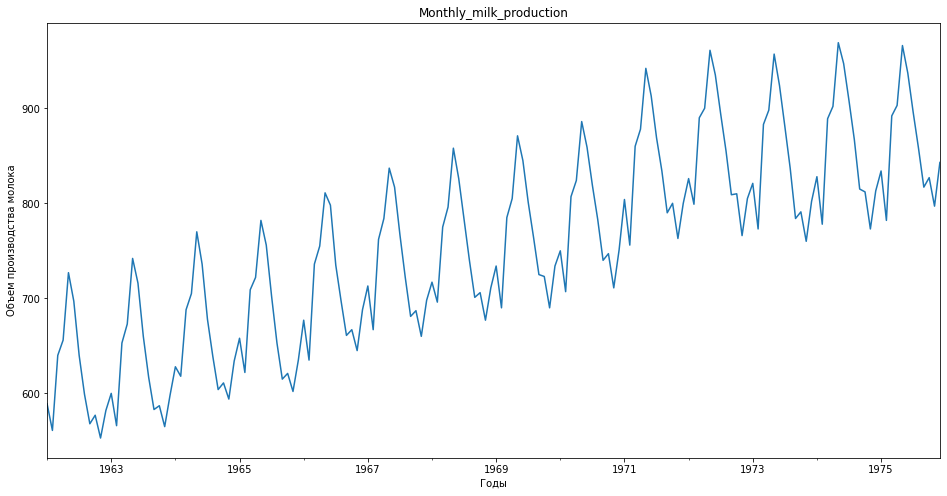

In [ ]:
#построим общий график для метрик
df['production'].plot(
    figsize=(16, 8), 
    title = 'Monthly_milk_production', 
    xlabel = 'Годы', 
    ylabel = 'Объем производства молока')

**Промежуточный вывод:**
 1. Мы видим общий восходящий тренд: с каждым последующим годом объем производства молока увеличивается;
 2. На определенных отрезках времени мы видим сезонные колебания производства молока ежегодно с максимальным значением в середине года.

**Строим гипотезу:** скорее всего производство молока в дальнейшем также будет увеличиваться с учетом сезонности.

## 5. Построение моделей, анализ результатов.

**5.1. Обучающая/контрольная выборки**

In [ ]:
#задаем размер тестовой выборки
delta = 12

#выделяем выборки
train = df.iloc[:len(df)-delta] #обучающая выборка
test = df.iloc[len(df)-delta:] #тестовая выборка

In [ ]:
train.head() #посмотрим на обучающую выборку

,date,production
date,,
1962-01-01,1962-01-01,589
1962-02-01,1962-02-01,561
1962-03-01,1962-03-01,640
1962-04-01,1962-04-01,656
1962-05-01,1962-05-01,727


In [ ]:
test.head() #и на тестовую выборку

,date,production
date,,
1975-01-01,1975-01-01,834
1975-02-01,1975-02-01,782
1975-03-01,1975-03-01,892
1975-04-01,1975-04-01,903
1975-05-01,1975-05-01,966


In [ ]:
#дополнительно создаем структуру для будущего сравнительного анализа качества моделей, наполняя ее постепенно в ходе построения моделей
mdl_qlt = [];

**5.2. ETS декомпозиция**

In [ ]:
#строим декомпозицию временного ряда (ETS декомпозиция)
r_add = seasonal_decompose(df['production'], model='date')

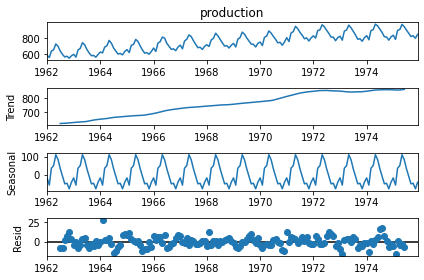

In [ ]:
r_add.plot();

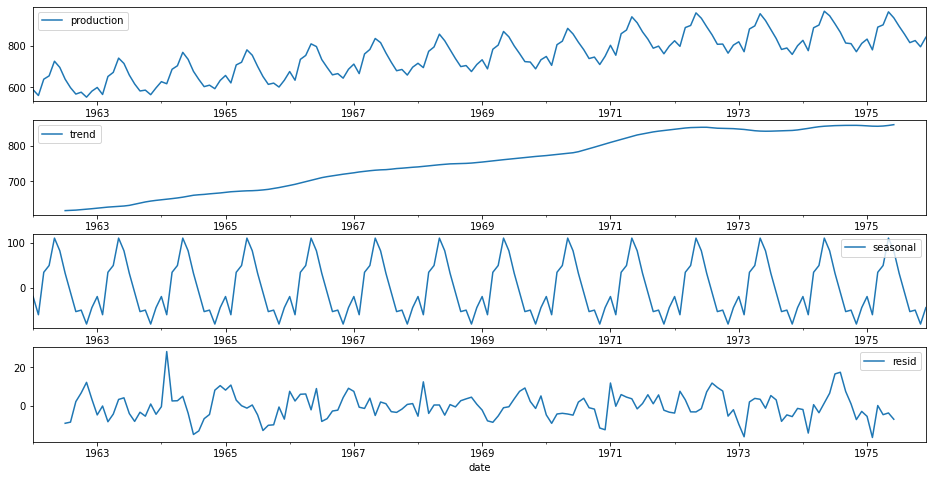

In [ ]:
#seasonal_decompose для лучшей наглядности в увеличенном виде
fig, (ax1,ax2,ax3,ax4) = plt.subplots(4,1, figsize=(16,8))
r_add.observed.plot(ax=ax1, legend=True)
r_add.trend.plot(ax=ax2, legend=True)
r_add.seasonal.plot(ax=ax3, legend=True)
r_add.resid.plot(ax=ax4, legend=True)

**Промежуточный вывод**:

Наблюдаем годовую сезонность и положительный (возрастающий) тренд.

**5.3 Построение моделей, анализ результатов.**

На данном этапе рассмотрим решение следующих задач:


*   Описать модель;
*   Подобрать оптимальные параметры;
*   Создать модель;
*   Обучить модель;
*   Сделать прогноз на период тестовой выборки;
*   Сравнить прогноз с тестовой выборкой (построить график);
*   Оценить качество прогноза;
*   Сделать прогноз на год;
*   Сделать выводы о работе данного метода прогнозирования.


**5.3.1 Метод прогнозирования - SARIMAX**

Сезонное авторегрессионное интегрированное скользящее среднее, SARIMA или Seasonal ARIMA, является расширением ARIMA, которое явно поддерживает одномерные данные временных рядов с сезонным компонентом.

Он добавляет три новых гиперпараметра для указания авторегрессии (AR), разности (I) и скользящего среднего (MA) для сезонной составляющей ряда, а также дополнительный параметр для периода сезонности.

Сезонная модель ARIMA формируется путем включения дополнительных сезонных терминов в ARIMA. Сезонная часть модели состоит из терминов, которые очень похожи на несезонные компоненты модели, но включают обратные сдвиги сезонного периода.

https://www.statsmodels.org/devel/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

In [ ]:
#Запустим pmdarima.auto_arima чтобы получить набор параметров для нашей модели
auto_arima(df['production'],seasonal=True, m=12).summary() #включаем сезонность и указываем период сезонности = 1 год

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                                    y   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -531.033
Date:                              Thu, 24 Mar 2022   AIC                           1072.066
Time:                                      23:24:51   BIC                           1087.315
Sample:                                           0   HQIC                          1078.260
                                              - 168                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.6062      0.905      1.775      0.076      -0.168       3.380
ar.L1          0.7310      0.084      8.737      0.000       0.567       0.895
ar.L2          0.1887      0.080      2.355      0.019       0.032       0.346
ma.S.L12      -0.6166      0.073     -8.403      0.000      -0.760      -0.473
sigma2        50.7122      4.915     10.317      0.000      41.078      60.346
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                42.72
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.83   Skew:                             0.78
Prob(H) (two-sided):                  0.52   Kurtosis:                         5.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Промежуточные выводы:

Ожидаемый результат ARIMA (2,0,0) с сезонностью (0,1,1,12)

In [ ]:
#обучаем модель с подобранными параметрами
model_sarimax = SARIMAX(train['production'],order=(2, 0, 0), seasonal_order=(0, 1, 1, 12))

results_sarimax = model_sarimax.fit() #обучаем модель на обучающей выборке данных

results_sarimax.summary() #получаем результаты

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  156
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -495.249
Date:                              Thu, 24 Mar 2022   AIC                            998.499
Time:                                      23:25:09   BIC                           1010.378
Sample:                                  01-01-1962   HQIC                          1003.326
                                       - 12-01-1974                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7425      0.083      8.987      0.000       0.581       0.904
ar.L2          0.2481      0.081      3.078      0.002       0.090       0.406
ma.S.L12      -0.6036      0.079     -7.664      0.000      -0.758      -0.449
sigma2        53.9908      5.477      9.858      0.000      43.257      64.725
===================================================================================
Ljung-Box (L1) (Q):                   0.04   Jarque-Bera (JB):                40.22
Prob(Q):                              0.83   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.79
Prob(H) (two-sided):                  0.59   Kurtosis:                         5.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
#получаем предсказанные значения и пытаемся оценить качество прогноза
start=len(train) #первая точка в тестовом множестве
end=len(train)+len(test)-1 #последняя точка в тестовом множестве

#предсказываем значения,передав модели results точку начала и окончания
predictions = results_sarimax.predict(start=start, end=end, dynamic=False, typ='levels').rename('Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12)')

In [ ]:
predictions

1975-01-01    838.035169
1975-02-01    793.263401
1975-03-01    898.045630
1975-04-01    912.082697
1975-05-01    975.177279
1975-06-01    948.588176
1975-07-01    906.942223
1975-08-01    866.129250
1975-09-01    816.804716
1975-10-01    818.688187
1975-11-01    781.859846
1975-12-01    821.687624
Freq: MS, Name: Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12), dtype: float64

[Text(0, 0.5, 'Объем производства молока'), Text(0.5, 0, 'Месяцы')]

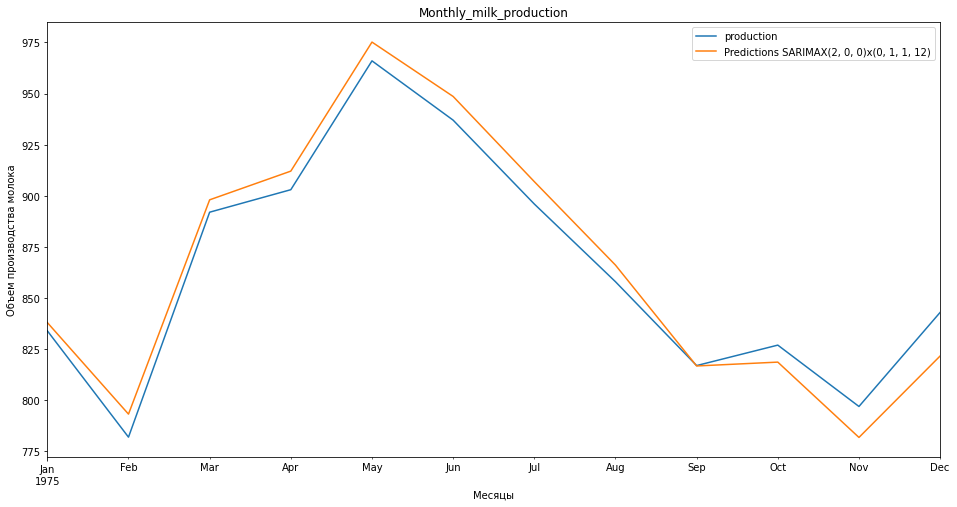

In [ ]:
#сравниваем результаты

title = 'Monthly_milk_production' #название графика
ylabel = 'Объем производства молока' #название оси Y
xlabel = 'Месяцы' #название оси Х
ax = test['production'].plot(legend=True, figsize=(16,8),title=title) #добавлем заголовок
predictions.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

Замечаем по двум графикам, что предсказанные значения визуально близки к тестовой выборке

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
mae_error = mean_absolute_error(test['production'], predictions)
mse_error = mean_squared_error(test['production'], predictions)
rmse_error = rmse(test['production'], predictions)
mape_error = np.mean(np.abs(predictions - test['production'])/test['production'])*100

print(f'Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) MAE Error: {mae_error:11.10}')
print(f'Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) MSE Error: {mse_error:11.10}') #квадрат от единиц измерения 11 - кол-во символов (с точкой), 10 - после точки (сколько останется, но макс 10)
print(f'Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) RMSE Error: {rmse_error:11.10}') #единицы те же, что и само измерение
print(f'Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) MAPE Error: {mape_error:11.10}')

Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) MAE Error:  9.60195423
Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) MSE Error:  118.256919
Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) RMSE Error: 10.87459972
Predictions SARIMAX(2, 0, 0)x(0, 1, 1, 12) MAPE Error: 1.118331538


In [ ]:
#добавляем данные в структуру оценки качетва моделей
mdl_qlt.append(['SARIMAX(2, 0, 0)x(0, 1, [1], 12)', mae_error, mse_error, rmse_error, mape_error])

In [ ]:
#проверяем
mdl_qlt

[['SARIMAX(2, 0, 0)x(0, 1, [1], 12)',
  9.601954230042915,
  118.25691896433852,
  10.87459971513152,
  1.1183315376812621]]

In [ ]:
#делаем прогноз на 1 год вперед и обучаем модель на всем датасете
fut_model_sarimax = SARIMAX(df['production'],order=(2, 0, 0), seasonal_order=(0, 1, 1, 12))
fut_results_sarimax = fut_model_sarimax.fit()
fut_results_sarimax.summary()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           production   No. Observations:                  168
Model:             SARIMAX(2, 0, 0)x(0, 1, [1], 12)   Log Likelihood                -534.194
Date:                              Thu, 24 Mar 2022   AIC                           1076.388
Time:                                      18:55:11   BIC                           1088.588
Sample:                                  01-01-1962   HQIC                          1081.343
                                       - 12-01-1975                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7698      0.078      9.873      0.000       0.617       0.923
ar.L2          0.2222      0.077      2.902      0.004       0.072       0.372
ma.S.L12      -0.6147      0.071     -8.620      0.000      -0.754      -0.475
sigma2        52.4950      5.089     10.315      0.000      42.521      62.470
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                37.50
Prob(Q):                              0.90   Prob(JB):                         0.00
Heteroskedasticity (H):               0.80   Skew:                             0.75
Prob(H) (two-sided):                  0.43   Kurtosis:                         4.88
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

[Text(0, 0.5, 'Объем производства'), Text(0.5, 0, 'Месяцы')]

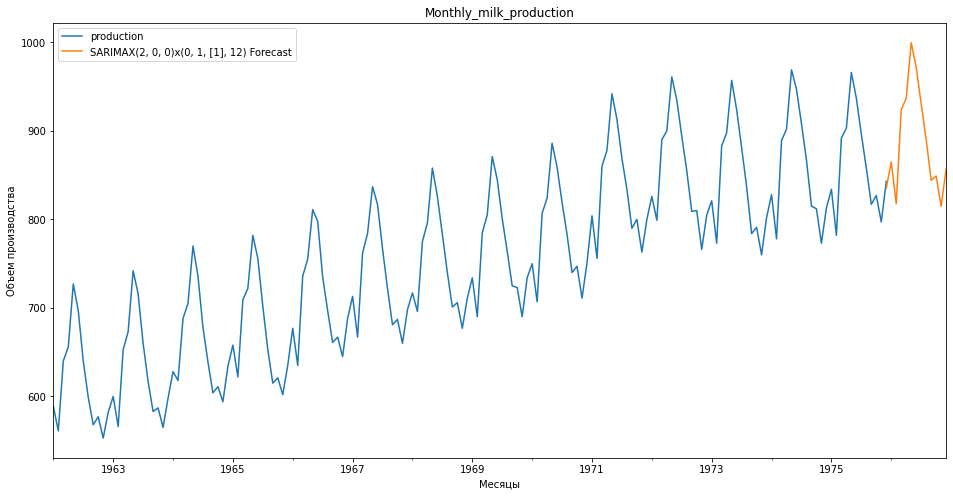

In [ ]:
# задаем точки будущего
fut_fcast_sarimax = fut_results_sarimax.predict(len(df)-1,len(df)+11,typ='levels').rename('SARIMAX(2, 0, 0)x(0, 1, [1], 12) Forecast')

# строим график на будущее
ax = df['production'].plot(legend=True, figsize=(16,8),title='Monthly_milk_production') 
fut_fcast_sarimax.plot(legend=True)
ax.autoscale(axis='x',tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)

**Выводы работы метода SARIMAX**
1. Модель показала себя хорошо: при среднеквадратическом отклонении (RMSE=10.87), процент рассчитанной ошибки равен MAPE=1.12% - это отличный результат.
2. Спрогнозировав модель на год вперед видим, что тренд на увеличение объема производства молока сохранился, высота амплитуды были отображены корректно. Общая динамика прослеживается.

**5.3.2 Метод прогнозирования - PROPHET**

Prophet — это библиотека с открытым исходным кодом от компании Facebook. Она предназначена для прогнозирования временных рядов. По словам разработчиков (команды Core Data Science team) данный инструмент хорошо работает с рядами, которые имеют ярко выраженные сезонные эффекты, а также имеют несколько таких периодов. Prophet устойчив к отсутствию данных и достаточно хорошо справляется с выбросами.
https://machinelearningmastery.com/time-series-forecasting-with-prophet-in-python/

In [ ]:
#подготовим данные для модели
train_prophet = train[['date','production']]
test_prophet = test[['date','production']]

#переименуем столбцы в обучающем и тестовом датасетах, чтобы они подходили для использования методов Prophet
train_prophet.columns = ['ds', 'y'] #переименовали столбцы
test_prophet.columns = ['ds', 'y'] #переименовали столбцы

In [ ]:
#подготовим данные по всему датасету для нашей модели
df_prophet = df[['date','production']]
df_prophet.columns = ['ds', 'y'] #переименовали столбцы

In [ ]:
#создаем модель с подобранными параметрами
model_prophet = Prophet(seasonality_mode='multiplicative') #создаем объект модели профет, не устанавливая параметры (модель самостоятельно подбирает параметры)

#обучаем модель на обучающей выборке данных
model_prophet.fit(train_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Промежуточные выводы:

Алгоритм проигнорировал, выбирая параметры:

1.   Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
- недельную сезонность (недельная сезонность может использоваться в случае, если данные собираются по дням, в нашем случае данные представлены по месяцам)
2.   INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
- дневную сезонность (дневная сезонность может использоваться в случае, если данные собираются по часам/минутам, в нашем случае данные представлены по месяцам).

Зато он обнаружил годовую сезонность и использовал её при настройке модели.

In [ ]:
#указываем профету сделать дата-фрейм на 1 год (delta=12 месяцев)
future_prophet = model_prophet.make_future_dataframe(periods=12,freq='MS')
future_prophet.tail(delta) #выводим 12 строк с конца

,ds
156,1975-01-01
157,1975-02-01
158,1975-03-01
159,1975-04-01
160,1975-05-01
161,1975-06-01
162,1975-07-01
163,1975-08-01
164,1975-09-01
165,1975-10-01


In [ ]:
#предсказываем значения по модели, доверительный интервал по умолчанию 95%
prediction_prophet = model_prophet.predict(future_prophet)
prediction_prophet.head() #возвращает много колонок

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,1962-01-01,609.121551,580.630639,603.172986,609.121551,609.121551,-0.028641,-0.028641,-0.028641,-0.028641,-0.028641,-0.028641,0.0,0.0,0.0,591.675607
1,1962-02-01,610.758135,547.723516,571.199129,610.758135,610.758135,-0.083603,-0.083603,-0.083603,-0.083603,-0.083603,-0.083603,0.0,0.0,0.0,559.696767
2,1962-03-01,612.236341,624.830129,647.764428,612.236341,612.236341,0.040227,0.040227,0.040227,0.040227,0.040227,0.040227,0.0,0.0,0.0,636.864745
3,1962-04-01,613.872925,639.964082,661.844418,613.872925,613.872925,0.061182,0.061182,0.061182,0.061182,0.061182,0.061182,0.0,0.0,0.0,651.431104
4,1962-05-01,615.456717,691.763980,714.270821,615.456717,615.456717,0.142265,0.142265,0.142265,0.142265,0.142265,0.142265,0.0,0.0,0.0,703.014677


In [ ]:
#устанавливаем индекс
prediction_prophet.index = prediction_prophet.ds
prediction_prophet.head() #проверим изменения

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1962-01-01,1962-01-01,609.121551,580.630639,603.172986,609.121551,609.121551,-0.028641,-0.028641,-0.028641,-0.028641,-0.028641,-0.028641,0.0,0.0,0.0,591.675607
1962-02-01,1962-02-01,610.758135,547.723516,571.199129,610.758135,610.758135,-0.083603,-0.083603,-0.083603,-0.083603,-0.083603,-0.083603,0.0,0.0,0.0,559.696767
1962-03-01,1962-03-01,612.236341,624.830129,647.764428,612.236341,612.236341,0.040227,0.040227,0.040227,0.040227,0.040227,0.040227,0.0,0.0,0.0,636.864745
1962-04-01,1962-04-01,613.872925,639.964082,661.844418,613.872925,613.872925,0.061182,0.061182,0.061182,0.061182,0.061182,0.061182,0.0,0.0,0.0,651.431104
1962-05-01,1962-05-01,615.456717,691.763980,714.270821,615.456717,615.456717,0.142265,0.142265,0.142265,0.142265,0.142265,0.142265,0.0,0.0,0.0,703.014677


Основные поля в прогнозе следующие:

*   ds — дата прогноза
*   yhat — спрогнозированное значение
*   yhat_lower — нижняя граница доверительного интервала для прогноза
*   yhat_upper — верхняя граница доверительного интервала для прогноза

In [ ]:
prediction_prophet[['ds', 'yhat']] #оставим только нужные столбцы

,ds,yhat
ds,,
1962-01-01,1962-01-01,591.675607
1962-02-01,1962-02-01,559.696767
1962-03-01,1962-03-01,636.864745
1962-04-01,1962-04-01,651.431104
1962-05-01,1962-05-01,703.014677
...,...,...
1975-08-01,1975-08-01,851.844276
1975-09-01,1975-09-01,802.749543
1975-10-01,1975-10-01,807.383016


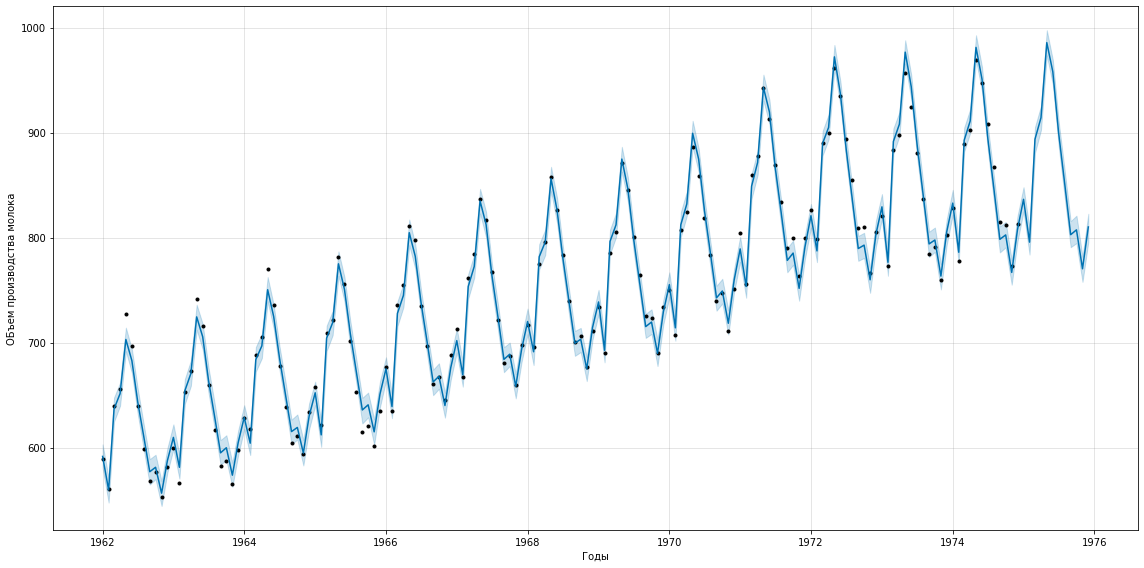

In [ ]:
#сравниваем прогноз и тестовую выборку, где черные точки - выборка
model_prophet.plot(prediction_prophet, figsize=(16,8), ylabel='ОБъем производства молока',  xlabel='Годы',);

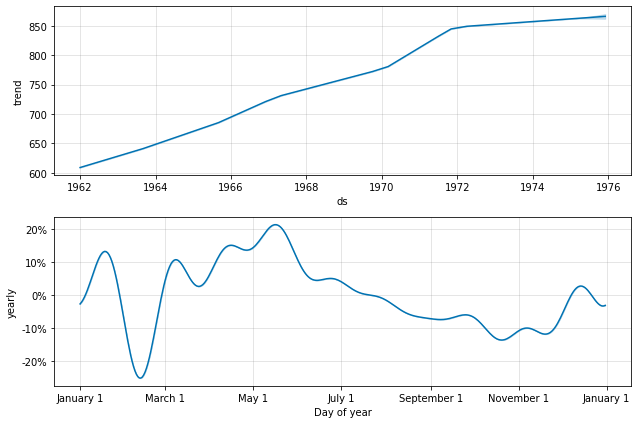

In [ ]:
#разложим ряд на основные компоненты — тренд и сезонность
model_prophet.plot_components(prediction_prophet);

Промежуточные выводы:


*   По графикам обращаем внимание на тренд производства молока - возрастающий, также есть годовая сезонность. 
*   Видим каким образом изменяется производство молока по месяцам. С мая по июнь объемы максимальны, в феврале - минимальны.






In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
pr_mae_error = mean_absolute_error(test_prophet['y'], prediction_prophet['yhat'].tail(delta))
pr_mse_error = mean_squared_error(test_prophet['y'], prediction_prophet['yhat'].tail(delta))
pr_rmse_error = rmse(test_prophet['y'], prediction_prophet['yhat'].tail(delta))
pr_mape_error = np.mean(np.abs(prediction_prophet['yhat'] - test_prophet['y'])/test_prophet['y'])*100

print(f'Prophet MAE Error: {pr_mae_error:11.10}')
print(f'Prophet MSE Error: {pr_mse_error:11.10}')
print(f'Prophet RMSE Error: {pr_rmse_error:11.10}')
print(f'Prophet MAPE Error: {pr_mape_error:11.10}')

Prophet MAE Error: 14.37304065
Prophet MSE Error: 297.4948351
Prophet RMSE Error: 17.24803859
Prophet MAPE Error: 1.682529777


In [ ]:
#добавляем данные в структуру оценки качеcтва моделей
mdl_qlt.append(['PROPHET', pr_mae_error, pr_mse_error, pr_rmse_error, pr_mape_error])

In [ ]:
#проверяем. должны выводится показатели по 2 методам
mdl_qlt

[['SARIMAX(2, 0, 0)x(0, 1, [1], 12)',
  9.601954230042915,
  118.25691896433852,
  10.87459971513152,
  1.1183315376812621],
 ['PROPHET',
  14.373040649171818,
  297.49483505885297,
  17.248038585846594,
  1.6825297768573253]]

In [ ]:
#делаем прогноз на будущее - 1 год вперед

#обучаем модель на всем датасете
fut_model_prophet = Prophet(seasonality_mode='multiplicative')
fut_model_prophet.fit(df_prophet)

#говорим профету сделать дата-фрейм на 1 год вперед
fut_future_prophet = fut_model_prophet.make_future_dataframe(periods=12, freq='MS')
fut_fcast_prophet = fut_model_prophet.predict(fut_future_prophet)

INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


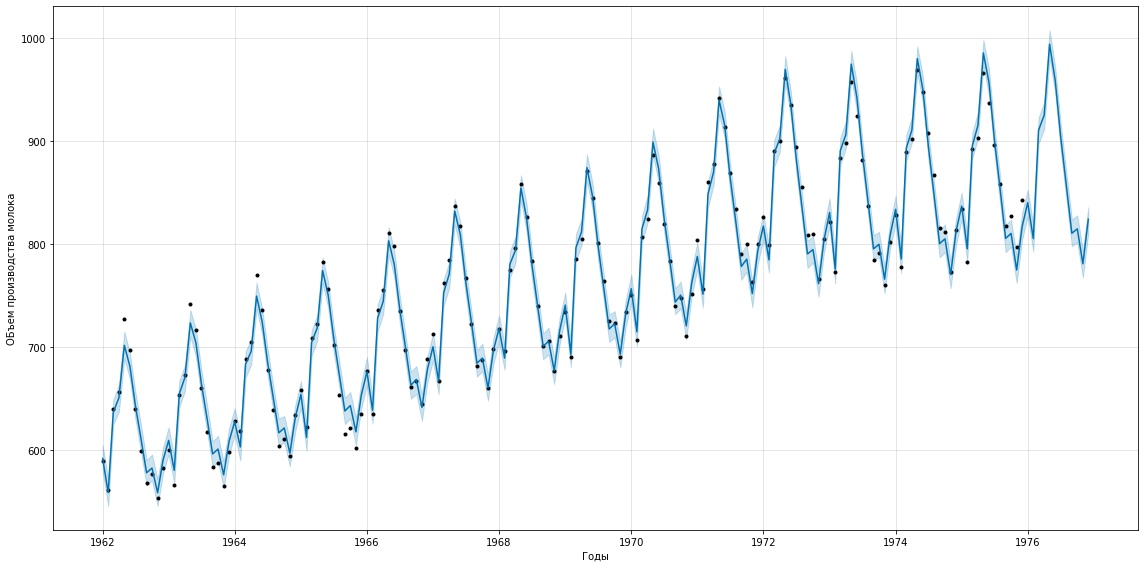

In [ ]:
#сравниваем прогноз и всю выборку, где черные точки - входная выборка
fut_model_prophet.plot(fut_fcast_prophet, figsize=(16,8), ylabel='ОБъем производства молока',  xlabel='Годы');

In [ ]:
#устанавливаем индекс
fut_fcast_prophet.index = fut_fcast_prophet.ds

In [ ]:
#убедимся в изменениях
fut_fcast_prophet.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
ds,,,,,,,,,,,,,,,,
1962-01-01,1962-01-01,608.476909,579.194199,604.716602,608.476909,608.476909,-0.027506,-0.027506,-0.027506,-0.027506,-0.027506,-0.027506,0.0,0.0,0.0,591.739954
1962-02-01,1962-02-01,610.141187,545.587205,572.012699,610.141187,610.141187,-0.084328,-0.084328,-0.084328,-0.084328,-0.084328,-0.084328,0.0,0.0,0.0,558.688903
1962-03-01,1962-03-01,611.644406,624.906626,648.884848,611.644406,611.644406,0.040672,0.040672,0.040672,0.040672,0.040672,0.040672,0.0,0.0,0.0,636.521481
1962-04-01,1962-04-01,613.308684,637.020718,663.077336,613.308684,613.308684,0.060701,0.060701,0.060701,0.060701,0.060701,0.060701,0.0,0.0,0.0,650.537191
1962-05-01,1962-05-01,614.919275,688.857395,714.921501,614.919275,614.919275,0.140784,0.140784,0.140784,0.140784,0.140784,0.140784,0.0,0.0,0.0,701.489814


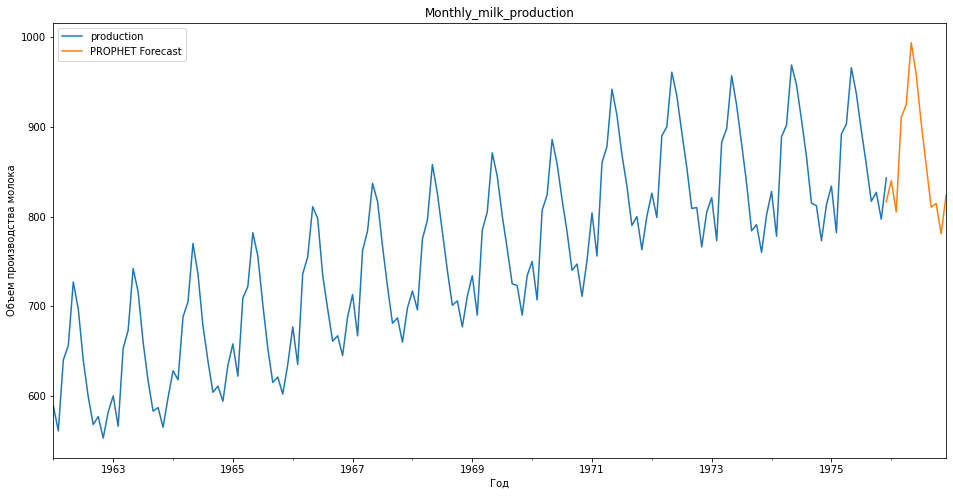

In [ ]:
#строим график на будущее
ax = df_prophet['y'].plot(legend=True, figsize=(16,8),title='Monthly_milk_production') 
fut_fcast_prophet['yhat'].tail(13).plot(legend=True, ylabel='Объем производства молока',  xlabel='Год',)
ax.autoscale(axis='x',tight=True)
ax.legend(["production", "PROPHET Forecast"]);

### Выводы работы метода PROPHET
1. Модель показала себя хорошо: при среднеквадратическом отклонении (RMSE=17.25), процент рассчитанной ошибки равен MAPE=1.68% - это хороший результат.
2. Спрогнозировав модель на год вперед видим, что тренд на увеличение объема производства молока сохранился, высота амплитуды были отображены корректно. Общая динамика прослеживается.


**5.3.3. Метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)**

Описание модели Exponential smoothing:

Экспоненциальное сглаживание — метод математического преобразования, используемый при прогнозировании временных рядов.

Метод также известен как метод простого экспоненциального сглаживания, или метод Брауна
https://www.statsmodels.org/dev/generated/statsmodels.tsa.holtwinters.ExponentialSmoothing.html

In [138]:
#создаем модель с подобранными параметрами используя метод Holt’s Winters:
model_exps = ExponentialSmoothing(train['production'], seasonal_periods=12, trend = 'add',seasonal="add",initialization_method="estimated",use_boxcox=True) #годовая сезонность

#обучаем модель на обучающей выборке данных
model_exps.fit()

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
#посмотрим на подобранные параметры модели
model_exps.params

{'damping_trend': nan,
 'initial_level': 69.17554457936508,
 'initial_seasons': array([-1.28240373, -3.41703331,  2.08957892,  2.97813637,  7.03528777,
         5.58306885,  2.1662592 , -0.82966974, -3.53551247, -3.37948581,
        -5.07829085, -2.79150912]),
 'initial_trend': 0.10277969876056059,
 'lamda': 0.5800323623132078,
 'remove_bias': False,
 'smoothing_level': 0.7095706846920204,
 'smoothing_seasonal': 0.17357941037248878,
 'smoothing_trend': 6.199659394392082e-13,
 'use_boxcox': True}

In [ ]:
#определяем точку начала для прогноза
test.index[0]

Timestamp('1975-01-01 00:00:00')

In [ ]:
#определяем точку окончания для прогноза
test.index[-1]

Timestamp('1975-12-01 00:00:00')

In [ ]:
#предсказываем значения,передав модели results точку начала и окончания
prediction_exps = model_exps.predict(model_exps.params, start=test.index[0], end=test.index[-1])

In [ ]:
prediction_exps

array([842.72306993, 801.91450945, 907.27712224, 921.84428347,
       987.8753026 , 962.64688563, 917.18551483, 871.12056876,
       820.64049012, 824.29450769, 790.57646565, 835.18093596])

In [ ]:
#преобразуем в датафрейм с индексами
prediction_exps = pd.DataFrame(prediction_exps)
prediction_exps.index = pd.date_range("1975-01-01 00:00:00", periods=12, freq="MS")

prediction_exps.columns = ['prediction_exps']

In [ ]:
#проверим
prediction_exps.head(12)

,prediction_exps
1975-01-01,842.723070
1975-02-01,801.914509
1975-03-01,907.277122
1975-04-01,921.844283
1975-05-01,987.875303
1975-06-01,962.646886
1975-07-01,917.185515
1975-08-01,871.120569
1975-09-01,820.640490
1975-10-01,824.294508


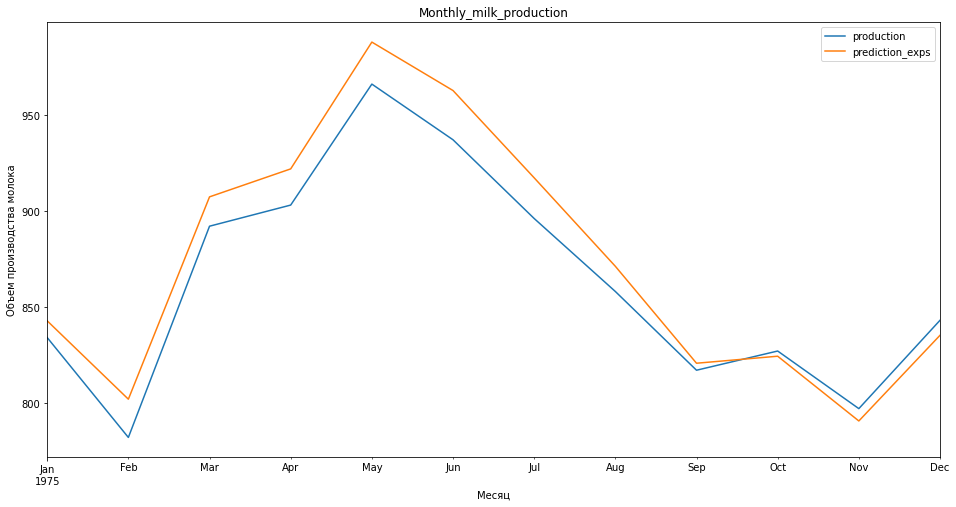

In [ ]:
#сравниваем прогноз и тестовую выборку
ax = test['production'].plot(legend=True, figsize=(16,8),title='Monthly_milk_production', ylabel='Объем производства молока',  xlabel='Месяц')
prediction_exps['prediction_exps'].plot(legend=True)
ax.autoscale(axis='x',tight=True)

In [ ]:
#оцениваем качество модели методом MSE, RMSE, MAE, MAPE
ex_mae_error = mean_absolute_error(test['production'], prediction_exps['prediction_exps'])
ex_mse_error = mean_squared_error(test['production'], prediction_exps['prediction_exps'])
ex_rmse_error = rmse(test['production'], prediction_exps['prediction_exps'])
ex_mape_error = np.mean(np.abs(prediction_exps['prediction_exps'] - test['production'])/test['production'])*100

print(f'MAE Error: {ex_mae_error:11.10}')
print(f'MSE Error: {ex_mse_error:11.10}')
print(f'RMSE Error: {ex_rmse_error:11.10}')
print(f'MAPE Error: {ex_mape_error:11.10}')

MAE Error: 13.76465315
MSE Error: 245.1180418
RMSE Error:  15.6562461
MAPE Error: 1.566134973


In [ ]:
#добавим данные в структуру оценки качества моделей
mdl_qlt.append(['prediction_exps', ex_mae_error, ex_mse_error, ex_rmse_error, ex_mape_error])

In [ ]:
#проверим структуру оценки качества уже моделей трех методов
mdl_qlt

[['SARIMAX(2, 0, 0)x(0, 1, [1], 12)',
  9.601954230042915,
  118.25691896433852,
  10.87459971513152,
  1.1183315376812621],
 ['PROPHET',
  14.373040649171818,
  297.49483505885297,
  17.248038585846594,
  1.6825297768573253],
 ['prediction_exps',
  13.76465314570738,
  245.11804184009137,
  15.656246096689058,
  1.566134972932112]]

In [ ]:
#делаем прогноз на год вперед

#обучаем модель на всем датасете
fut_model_exps = ExponentialSmoothing(df['production'], seasonal_periods=12, trend = 'add',seasonal="add",initialization_method="estimated",use_boxcox=True) #годовая сезонность
fut_model_exps.fit()

#задаем точки будущего
fut_fcast_exps = fut_model_exps.predict(fut_model_exps.params, start=len(df)-1, end=len(df)+11)

#преобразуем в датафрейм с индексами
fut_fcast_exps = pd.DataFrame(fut_fcast_exps)
fut_fcast_exps.index = pd.date_range("1975-12-01 00:00:00", periods=13, freq="MS")
fut_fcast_exps.columns = ['fut_fcast_exps']

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [ ]:
#проверим
fut_fcast_exps.head(12)

,fut_fcast_exps
1975-12-01,839.476879
1976-01-01,868.992660
1976-02-01,827.340829
1976-03-01,934.228489
1976-04-01,946.368730
1976-05-01,1010.277357
1976-06-01,983.764587
1976-07-01,940.198759
1976-08-01,896.351364
1976-09-01,848.056433


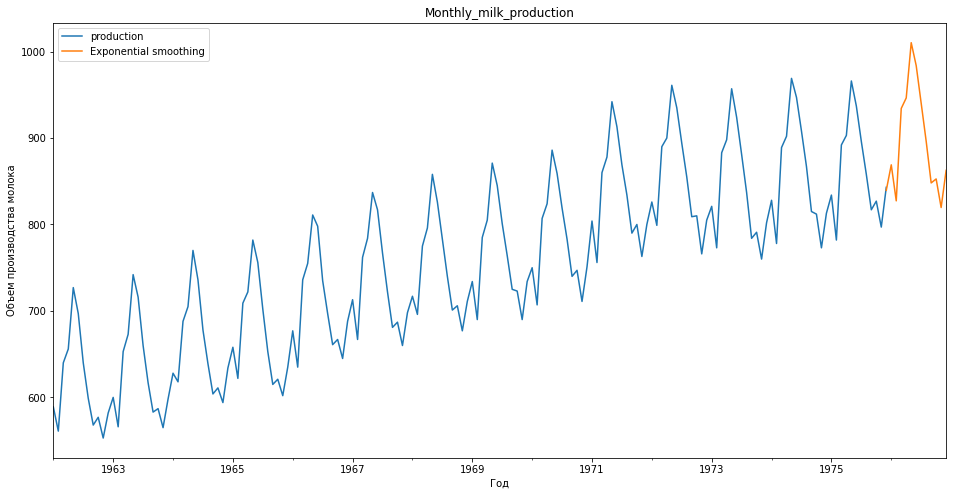

In [ ]:
#строим график на будущее
ax = df['production'].plot(legend=True, figsize=(16,8),title='Monthly_milk_production') 
fut_fcast_exps['fut_fcast_exps'].tail(13).plot(legend=True, ylabel='Объем производства молока',  xlabel='Год')
ax.autoscale(axis='x',tight=True)
ax.legend(["production", "Exponential smoothing"]);

### Выводы работы метода Exponential smoothing
1. Модель показала себя хорошо: при среднеквадратическом отклонении (RMSE=15.65), процент рассчитанной ошибки равен MAPE=1.57% - это отличный результат.
2. Спрогнозировав модель на год вперед видим, что тренд на увеличение объема производства молока сохранился, высота амплитуды были отображены корректно. Общая динамика прослеживается.

**6. Сравнение качеcтва моделей**

В ходе проведения анализа возможного увеличения объема производства молока мы рассмотрели 3 модели прогнозирования:
  
1.   Метод прогнозирования - SARIMAX
2.   Метод прогнозирования - PROPHET
3.   Метод прогнозирования "Экспоненциальное сглаживание" (Exponential smoothing)

Для того, чтобы оценить какой из методов оказался наиболее эффективным, сравним основные оценки качества моделей MSE, RMSE, MAE, MAPE. 


In [ ]:
#преобразуем структуру оценки качества моделей в датафрейм с названием ошибок
df_mdl_qlt = pd.DataFrame(mdl_qlt, columns = ['model', 'mae_error', 'mse_error', 'rmse_error', 'mape_error'])

In [ ]:
#выведем полученный датасет
df_mdl_qlt

,model,mae_error,mse_error,rmse_error,mape_error
0,"SARIMAX(2, 0, 0)x(0, 1, [1], 12)",9.601954,118.256919,10.874600,1.118332
1,PROPHET,14.373041,297.494835,17.248039,1.682530
2,prediction_exps,13.764653,245.118042,15.656246,1.566135


*   MAE - средняя абсолютная ошибка
*   MSE - средняя квадратичная ошибка
*   RMSE - корень из средней квадратичной ошибки
*   MAPE - средняя абсолютная процентная ошибка

Исходя из показателей rmse и mape делаем вывод, что модель SARIMAX(2, 0, 0)x(0, 1, 1, 12) являетя наиболее качественной, т.к. выдаёт наименьшие ошибки по каждому из критериев.


**7. ИТОГ**

- Проведен анализ данных с использованием различных методов обработки статистической информации (рассмотрели три варианта). 
- Рассчитаны основные статистические метрики, позволяющие судить о характере исследуемого явления.
- Изначальный прогноз оправдался. Мы заметили, что в каждом из методов оценки ожидался дальнейший рост производства молока в последующий год.
- Исходя из значений расчитанных метрик пришли к выводу, что наиболее качественной из построенных является модель SARIMAX.